In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT

import numpy as np

 We implement a Qiskit function `shoracle` that takes two inputs, $a,N \in \mathbb{Z}_{>0}$ such that $a <N$ and outputs the circuit (an oracle for Shor's algorithm)
 $$ U |x\rangle_1 |y\rangle_n = \begin{cases}
 |x\rangle_1 |ay \mod N\rangle_n & \mbox{if }x=1, y<N ,\\
 |x\rangle_1 |y\rangle_n & \mbox{otherwise}
 \end{cases} $$
 where $n =2 \lceil \log_2 N \rceil$. The function also uses 3 additional ancillas.

This function is based off Beauregard's controlled modular multiplication circuit [1], which implements modular multiplication as an appropriate sequence of additions / subtractions. The addition / subtraction operations use Draper's QFT-based adder circuit. 

The first part of the circuit detects when $y \geq N$, by (1) subtracting $N$ from $y$, (2) detecting whether there is underflow and storing this information in an ancilla, and (3) adding $N$ back. The rest of the circuit is also controlled on the ancilla from this step, and so has one more control qubit than Beauregard's circuit.

Otherwise, the rest of the circuit follows Beauregard's design. This uses the identity
$$ ax \mod N = (\dots ((2^0ax_0) \mod N + 2^1ax_1)\mod N + ... + 2^{n−1}ax_{n−1})\mod N $$
where $x = 2^{n-1}x_{n-1} + \dots + 2^0 x_0$.
This identity allows us to implement controlled modular multiplication as a series of modular adders, plus some additional circuitry (see Figure 7 in Beauregard's paper). 

To implement addition modulo $N$: the circuit (1) uses ancillas to carry possible overflow, then (2) subtracts $N$ and uses another ancilla to detect whether there is underflow (i.e. if it was necessary to subtract $N$, and (3) undoes the previous subtraction if it is not necessary, and finally (4) restores the last ancilla using essentially the same technique.

**References**

[1] Stéphane Beauregard, "Circuit for Shor's algorithm using 2n+3 qubits", *Quant. Inf. Comput.* 3 (2003) 2, 175-185. DOI: 10.26421/QIC3.2-8. Preprint:[arXiv:quant-ph/0205095](https://arxiv.org/pdf/quant-ph/0205095)

In [167]:
def shoracle(a,N):
    if a >= N: raise Exception("Invalid inputs!")

    # classical precomputation
    n = int(np.ceil(np.log2(N)))
    apow = [[(a*(1<<i)%N)*np.pi/(1<<j) for j in range(n+1)] for i in range(n+1)]
    Npow = [N*np.pi/(1<<j) for j in range(n+1)]
    # find ainv using Euclid's algorithm
    ainv = pow(a, -1, N)
    aipow = [[(ainv*(1<<i)%N)*np.pi/(1<<j) for j in range(n+1)] for i in range(n+1)]
    
    ctrl = QuantumRegister(size=1, name="x")
    reg0 = QuantumRegister(size=n, name="y0")
    reg1 = QuantumRegister(size=n, name="y1")
    anci = QuantumRegister(size=3, name="z")
    circ = QuantumCircuit(ctrl, reg0, reg1, anci, name="U_a")

    # entire y register + overflow ancilla
    yreg = [1+i for i in range(2*n+1)]
    # subtract N
    circ.compose(QFT(2*n+1), qubits=yreg, inplace=True)
    circ.p(-N*np.pi, anci[0])
    for k in range(1,n+1): 
        circ.p(-N*np.pi/(1<<k),reg1[n-k])        
        circ.p(-N*np.pi/(1<<(n+k)),reg0[n-k])
    circ.compose(QFT(2*n+1).inverse(), qubits=yreg, inplace=True)
    # mark last ancilla 1 iff underflow (i.e. iff y<N)
    circ.cx(anci[0],anci[2])    
    # add N back
    circ.compose(QFT(2*n+1), qubits=yreg, inplace=True)
    circ.p(N*np.pi, anci[0])
    for k in range(1,n+1): 
        circ.p(N*np.pi/(1<<k),reg1[n-k])        
        circ.p(N*np.pi/(1<<(n+k)),reg0[n-k])
    circ.compose(QFT(2*n+1).inverse(), qubits=yreg, inplace=True)

    breg = [n+1+i for i in range(n+1)]
    
    # triple-controlled +*a mod N
    circ.compose(QFT(n+1), qubits=breg, inplace=True)
    for i in range(n):
        # add 2^i*a
        circ.mcp(apow[i][0], [anci[2],ctrl,reg0[i]], anci[0])
        for k in range(1,n+1): circ.mcp(apow[i][k], [anci[2],ctrl,reg0[i]], reg1[n-k])
        
        # subtract N
        circ.cp(-Npow[0], anci[2],anci[0])
        for k in range(1,n+1): circ.cp(-Npow[k],anci[2],reg1[n-k])        
        
        # undo subtract N if not needed
        circ.compose(QFT(n+1).inverse(), qubits=breg, inplace=True)
        circ.cx(anci[0],anci[1])
        circ.compose(QFT(n+1), qubits=breg, inplace=True)
        circ.mcp(Npow[0],[anci[2],anci[1]],anci[0])
        for k in range(1,n+1): circ.mcp(Npow[k],[anci[2],anci[1]],reg1[n-k])
        
        # clean ancilla
        circ.mcp(-apow[i][0], [anci[2],ctrl,reg0[i]], anci[0])
        for k in range(1,n+1): circ.mcp(-apow[i][k], [anci[2],ctrl,reg0[i]], reg1[n-k])
        circ.compose(QFT(n+1).inverse(), qubits=breg, inplace=True)
        circ.cx(anci[2],anci[0])
        circ.cx(anci[0],anci[1])
        circ.cx(anci[2],anci[0])
        circ.compose(QFT(n+1), qubits=breg, inplace=True)
        circ.mcp(apow[i][0], [anci[2],ctrl,reg0[i]], anci[0])
        for k in range(1,n+1): circ.mcp(apow[i][k], [anci[2],ctrl,reg0[i]], reg1[n-k])
    circ.compose(QFT(n+1).inverse(), qubits=breg, inplace=True)

    for i in range(n):
        #circ.ccswap([anci[2],ctrl],reg0[i],reg1[i])
        circ.cx(reg1[i],reg0[i])
        circ.mcx([anci[2],ctrl,reg0[i]],reg1[i])
        circ.cx(reg1[i],reg0[i])
    
    # controlled inverse-*a^{-1} mod N
    circ.compose(QFT(n+1), qubits=breg, inplace=True)
    for j in range(n):
        i = n-1-j
        # inverse (clean ancilla)
        circ.mcp(-aipow[i][0], [anci[2],ctrl,reg0[i]], anci[0])
        for k in range(1,n+1): circ.mcp(-aipow[i][k], [anci[2],ctrl,reg0[i]], reg1[n-k])
        circ.compose(QFT(n+1).inverse(), qubits=breg, inplace=True)
        circ.cx(anci[2],anci[0])
        circ.cx(anci[0],anci[1])
        circ.cx(anci[2],anci[0])
        circ.compose(QFT(n+1), qubits=breg, inplace=True)
        circ.mcp(aipow[i][0], [anci[2],ctrl,reg0[i]], anci[0])
        for k in range(1,n+1): circ.mcp(aipow[i][k], [anci[2],ctrl,reg0[i]], reg1[n-k])

        # inverse (undo subtract N if not needed)
        circ.mcp(-Npow[0],[anci[2],anci[1]],anci[0])
        for k in range(1,n+1): circ.mcp(-Npow[k],[anci[2],anci[1]],reg1[n-k])
        circ.compose(QFT(n+1).inverse(), qubits=breg, inplace=True)
        circ.cx(anci[0],anci[1])
        circ.compose(QFT(n+1), qubits=breg, inplace=True)
        
        # inverse (subtract N)
        circ.cp(Npow[0], anci[2], anci[0])
        for k in range(1,n+1): circ.cp(Npow[k],anci[2],reg1[n-k])        

        # inverse (double-controlled) add 2^i*a
        circ.mcp(-aipow[i][0], [anci[2],ctrl,reg0[i]], anci[0])
        for k in range(1,n+1): circ.mcp(-aipow[i][k], [anci[2],ctrl,reg0[i]], reg1[n-k])
    circ.compose(QFT(n+1).inverse(), qubits=breg, inplace=True)
    
    return circ

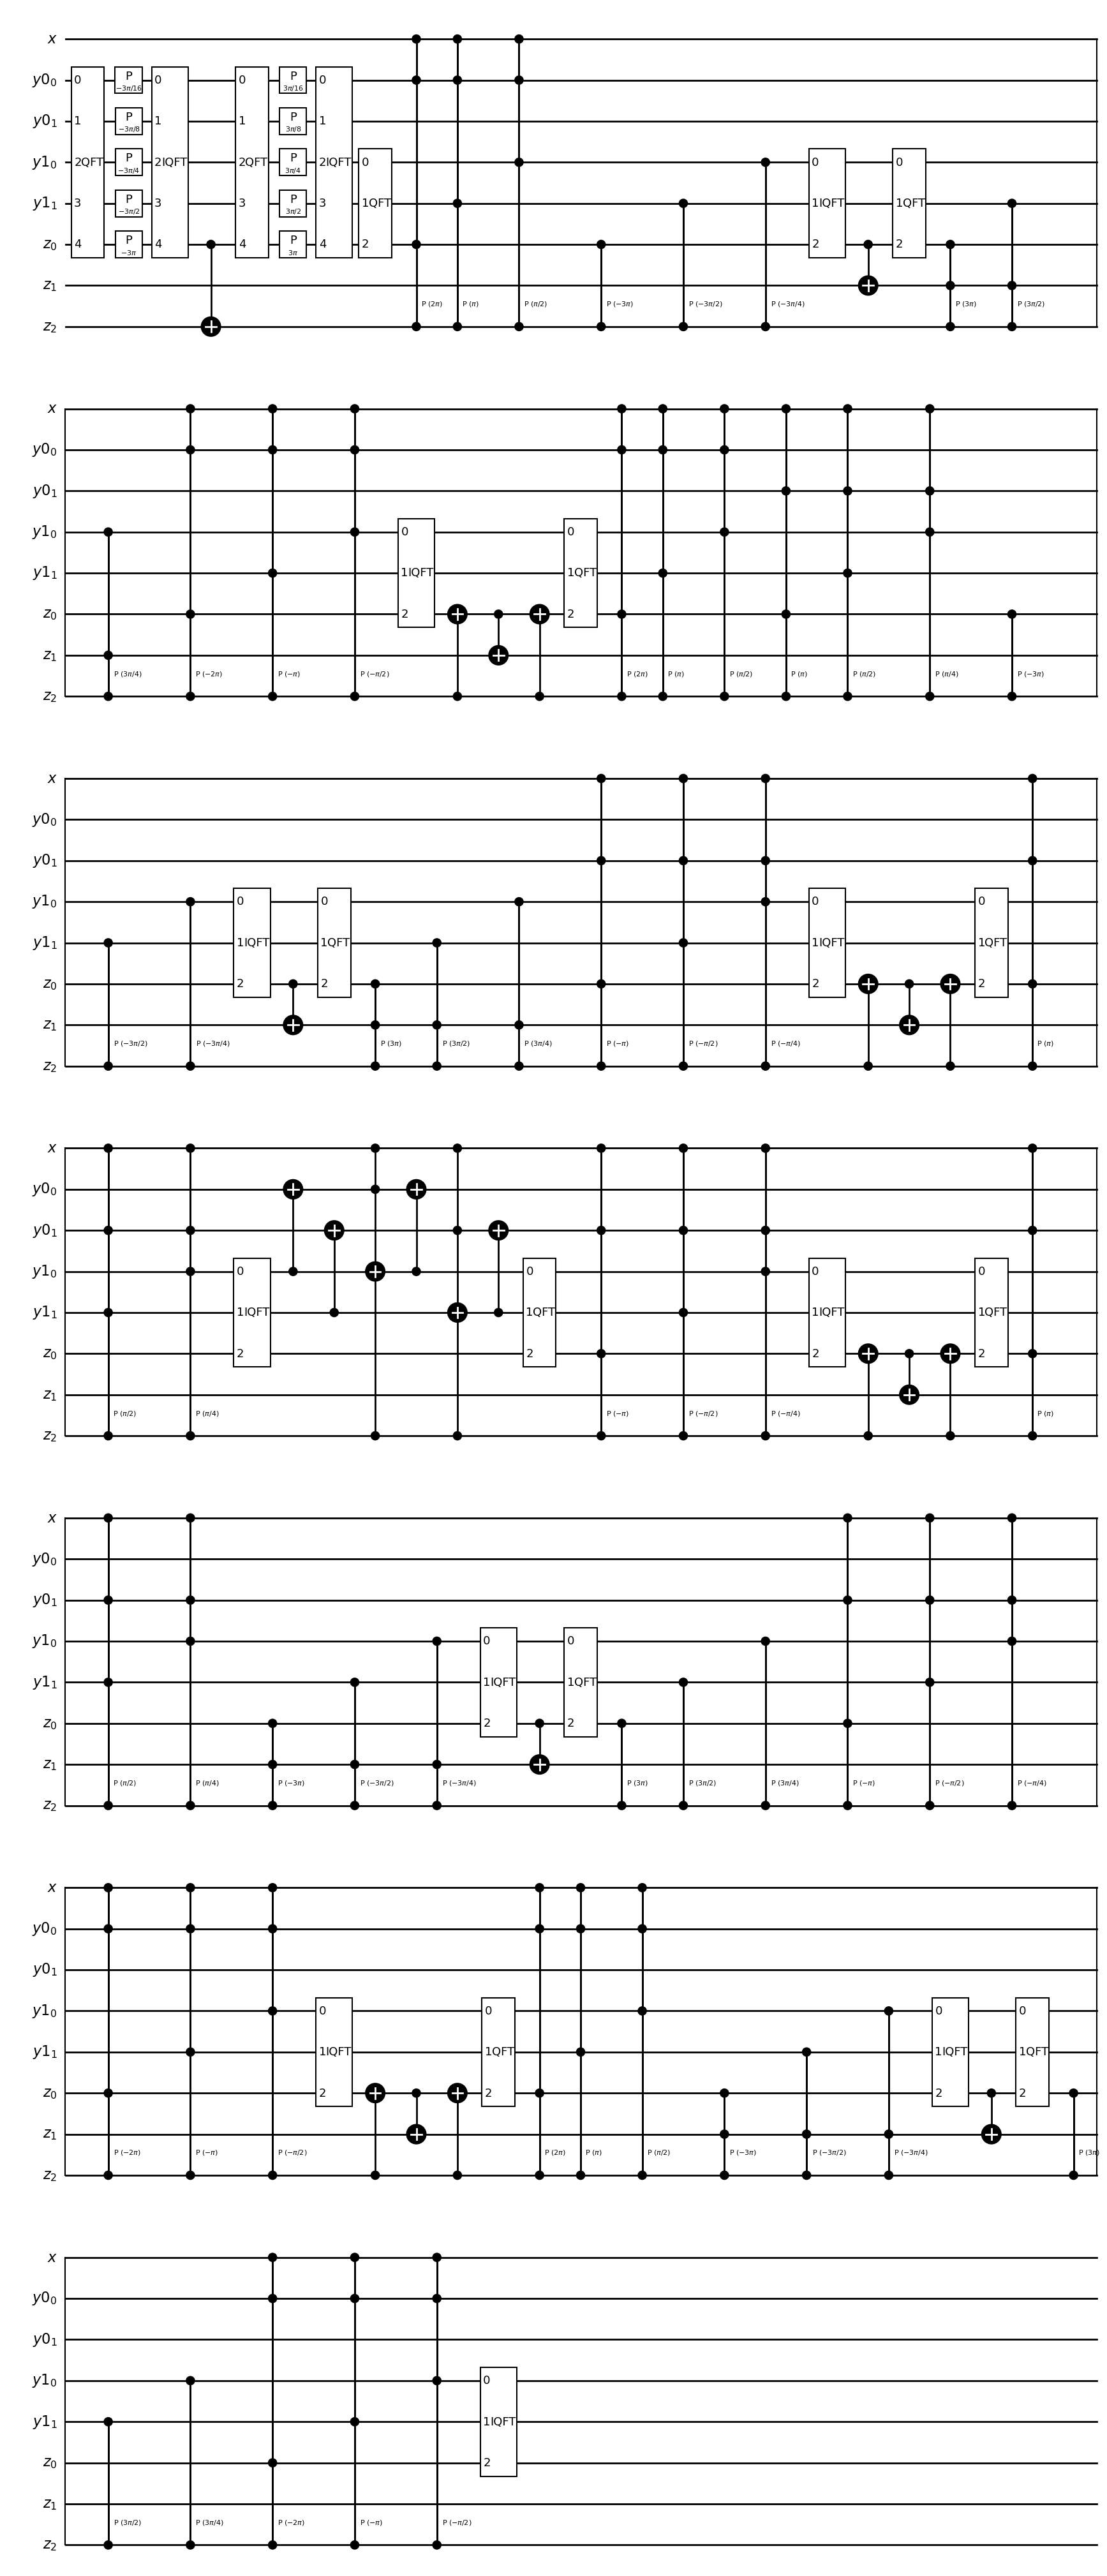

In [168]:
shoracle(2,3).draw(output="mpl",style="bw")

**Asymptotic complexity analysis**

This circuit uses $n+4$ qubits (including 3 ancillas), where $n = 2\lceil \log_2 N \rceil$ as defined above.

It uses $O(n)$ many QFTs / inverse QFTs and $O(n^2)$ many other gates (which are elementary or can be reduced to $O(1)$ many elementary gates). Since the QFT uses $O(n^2)$ many Hadamard + controlled phase gates with $O(n)$ depth, the entire circuit uses $O(n^3)$ gates with $O(n^2)$ depth.

We can reduce the complexity by using an approximate QFT where we do not perform phase shifts below a specified threshold; this reduces the number of gates needed from $O(n^3)$ to $O(n^2 \log n)$.

**Demonstration**

Let us now test / demonstrate this function. We write a testing function for this purpose:

In [165]:
def test_shoracle(a,N,x,y):
    n = int(np.ceil(np.log2(N)))
    ctrl = QuantumRegister(size=1, name="x")
    reg = QuantumRegister(size=2*n, name="y")
    anc = AncillaRegister(size=3, name="z")

    # prepare input state
    qcirc = QuantumCircuit(ctrl,reg,anc)
    if x: qcirc.x(ctrl)
    iqbits = [(y>>k&1) for k in range(2*n)]
    for i in range(2*n): 
        if iqbits[i]: qcirc.x(reg[i])

    # build circuit
    qcirc.compose(shoracle(a,N),inplace=True)

    # run circuit
    vec = Statevector(qcirc)
    # look at output
    probs = np.array(vec.probabilities())
    bits = [(np.argmax(probs)>>k&1) for k in range(2*n+4)]
    print("max prob at state", np.argmax(probs),bits,"of",np.max(probs),": |y>=", (np.argmax(probs)>>1)%(1<<(2*n)))

**Testing for $N=7$**

In [169]:
test_shoracle(4,7,True,3)

max prob at state 523 [1, 1, 0, 1, 0, 0, 0, 0, 0, 1] of 0.9999999999999947 : |y>= 5


This corresponds to output state $|1\rangle |5\rangle_6$, given input state $|1\rangle |3\rangle_6$, which corresponds to $4 \cdot 3 \equiv 5 \mod 7$.

**Testing for $N=15$**

In [170]:
test_shoracle(8,15,True,3)

max prob at state 2067 [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1] of 0.9999999999999987 : |y>= 9


This corresponds to output state $|1\rangle |9\rangle_8$, given input state $|1\rangle |3\rangle_8$, which corresponds to $8 \cdot 3 \equiv 9 \mod 15$.

In [171]:
test_shoracle(8,15,True,11)

max prob at state 2075 [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1] of 1.0 : |y>= 13


This corresponds to output state $|1\rangle |13\rangle_8$, given input state $|1\rangle |11\rangle_8$, which corresponds to $8 \cdot 11 \equiv 13 \mod 15$.

In [172]:
test_shoracle(8,15,True,15)

max prob at state 31 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0] of 0.9999999999999964 : |y>= 15


This corresponds to output state $|1\rangle |15\rangle_8$, given input state $|1\rangle |15\rangle_8$: in this case, since $y \geq N$, the circuit does not do anything to $|x\rangle |y\rangle$.

In [173]:
test_shoracle(8,15,False,3)

max prob at state 2054 [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1] of 1.0 : |y>= 3


The circuit similarly does not do anything to $|x\rangle |y\rangle$ if $x=0$.

**Testing for $N> 15$**

In [174]:
test_shoracle(7,16,True,9)

max prob at state 2079 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1] of 0.9999999999999778 : |y>= 15


This corresponds to output state $|1\rangle |15\rangle_{10}$, given input state $|1\rangle |9\rangle_{10}$, which corresponds to $7 \cdot 9 \equiv 15 \mod 16$. 

In [175]:
test_shoracle(8,31,True,5)

max prob at state 8211 [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1] of 0.999999999999972 : |y>= 9


This corresponds to output state $|1\rangle |9\rangle_{10}$, given input state $|1\rangle |5\rangle_{10}$, which corresponds to $8 \cdot 5 \equiv 9 \mod 31$. 

In [179]:
test_shoracle(10,21,True,15)

max prob at state 8199 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] of 0.9999999999999938 : |y>= 3


This corresponds to output state $|1\rangle |3\rangle_{10}$, given input state $|1\rangle |15\rangle_{10}$, which corresponds to $10 \cdot 15 \equiv 3 \mod 21$. 